In [23]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [24]:
DEVICE = "cpu"

print(torch.cuda.is_available())
if torch.cuda.is_available():
    DEVICE = "cuda:0"


True


In [25]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
        , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_dataset = torchvision.datasets.CIFAR10(root='./data'
                                             , train=True
                                             , download=True
                                             , transform=transform)
train_loader = DataLoader(train_dataset
                          , batch_size=64
                          , shuffle=True
                          , num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data'
                                            , train=False
                                            , download=True
                                            , transform=transform)
test_loader = DataLoader(test_dataset
                         , batch_size=64
                         , shuffle=False
                         , num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


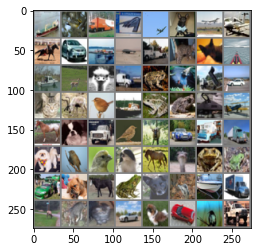

ship	bird	truck	airplane	airplane	dog	airplane	airplane	horse	automobile	airplane	airplane	truck	cat	cat	ship	ship	deer	bird	truck	frog	bird	truck	automobile	cat	deer	bird	ship	frog	frog	airplane	airplane	horse	dog	automobile	bird	deer	automobile	truck	truck	dog	bird	bird	dog	horse	bird	frog	frog	automobile	dog	horse	frog	dog	bird	ship	truck	deer	cat	cat	automobile	dog	automobile	bird	truck	

In [27]:
def imshow(img: torch.Tensor):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

for i in range(len(labels)):
    print(classes[labels[i]], end="\t")

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=3, stride=1, padding=1)
            , nn.BatchNorm2d(24)
            , nn.ReLU()
            , nn.Conv2d(24, 32, kernel_size=3, stride=1, padding=1)
            , nn.BatchNorm2d(32)
            , nn.ReLU()
            , nn.MaxPool2d(kernel_size=2, stride=2)
            , nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            , nn.BatchNorm2d(64)
            , nn.ReLU()
            , nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
            , nn.BatchNorm2d(64)
            , nn.ReLU()
            , nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5)
            , nn.Linear(32 * 32 * 4, 64)
            , nn.BatchNorm1d(64)
            , nn.ReLU()
            , nn.Dropout(0.5)
            , nn.Linear(64, 256)
            , nn.BatchNorm1d(256)
            , nn.ReLU()
            , nn.Linear(256, 10) # 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [29]:
net = Net()
net.cuda()
net

Net(
  (features): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
steplr = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [31]:
def train(epoch):
    net.train()
    steplr.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1)% 100 == 0:
            print(f'Train Epoch: {epoch + 1} --> {(batch_idx + 1) * len(data)}/{len(train_loader.dataset)} '
                  f'({100.0 * (batch_idx + 1) / len(train_loader):.0f}%)\tLoss: {loss.data.item():.6f}')

In [32]:
def evaluate(data_loader: DataLoader):
    net.eval()
    LOSS = 0
    CORRECT = 0

    for data, target in data_loader:
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        out = net(data)

        LOSS += F.cross_entropy(out, target, size_average=False).data.item()
        pred = out.data.max(1, keepdim=True)[1]
        CORRECT += pred.eq(target.data.view_as(pred)).cpu().sum()

    LOSS /= len(data_loader.dataset)

    print(f'\nLoss: {LOSS:.4f} \t Val Accuracy: {CORRECT}/{len(data_loader.dataset)} '
          f'({100.0 * CORRECT / len(data_loader.dataset):.3f}%)\n')

In [33]:
EPOCHS = 30

for i in range(EPOCHS):
    train(i)
    evaluate(test_loader)


Train Epoch: 1 --> 6400/50000 (13%)	Loss: 1.528944
Train Epoch: 1 --> 12800/50000 (26%)	Loss: 1.527427
Train Epoch: 1 --> 19200/50000 (38%)	Loss: 1.391088
Train Epoch: 1 --> 25600/50000 (51%)	Loss: 1.476630
Train Epoch: 1 --> 32000/50000 (64%)	Loss: 1.335822
Train Epoch: 1 --> 38400/50000 (77%)	Loss: 1.103624
Train Epoch: 1 --> 44800/50000 (90%)	Loss: 1.417225

Loss: 1.1516 	 Val Accuracy: 6007/10000 (60.070%)

Train Epoch: 2 --> 6400/50000 (13%)	Loss: 1.154640
Train Epoch: 2 --> 12800/50000 (26%)	Loss: 1.187910
Train Epoch: 2 --> 19200/50000 (38%)	Loss: 1.237151
Train Epoch: 2 --> 25600/50000 (51%)	Loss: 0.917400
Train Epoch: 2 --> 32000/50000 (64%)	Loss: 0.921841
Train Epoch: 2 --> 38400/50000 (77%)	Loss: 1.146829
Train Epoch: 2 --> 44800/50000 (90%)	Loss: 1.238381

Loss: 0.8409 	 Val Accuracy: 7079/10000 (70.790%)

Train Epoch: 3 --> 6400/50000 (13%)	Loss: 1.305899
Train Epoch: 3 --> 12800/50000 (26%)	Loss: 1.053710
Train Epoch: 3 --> 19200/50000 (38%)	Loss: 0.948166
Train Epoch: 3 